# Machine learning research section

In [ ]:
import os
import tensorflow as tf
import numpy as np
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPool1D, MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import glob
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix 

In [ ]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'auc', 'precision', 'recall']
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(2,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],
             color=colors[0], linestyle="--", label='Val')
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1])
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

# DNN for Kinect

In [ ]:
# This will store arrays of data from files
features = []
# This will store 1 for good and 0 for wrong(bad)
labels = []

for files in glob.glob('distrib_kinect/*.csv'):
    d = pd.read_csv(str(files)).values
    if 'G' in files or 'A' in files:
        labels.append(1)
    else:
        labels.append(0)
    features.append(d)
    
# Convert them to numpy arrays, cause easier
features = np.array(features)
labels = np.array(labels)

print(features.shape)

# Scale the data
scalers = {}
for i in range(features.shape[1]):
    scalers[i] = StandardScaler()
    features[:, i, :] = scalers[i].fit_transform(features[:, i, :])

for i in range(features.shape[1]):
    features[:, i, :] = scalers[i].transform(features[:, i, :])

(3616, 10, 39)


In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# split data into train, test, val
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

def make_model6():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=x_test[0].shape))
    model.add(tf.keras.layers.Dense(8, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(64, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-4), metrics = METRICS)
    return model


# construct model
model6 = make_model6()
model6.summary()
                
# compile
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)
# fit model
baseline_history6 = model6.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, verbose=0, batch_size=8, callbacks=[es])
baseline_results6 = model6.evaluate(x_test, y_test, batch_size=8, verbose=0)

for name, value in zip(model6.metrics_names, baseline_results6):
    print(name, ': ', value)
print()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 8)             320       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 8)             32        
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
____________________________

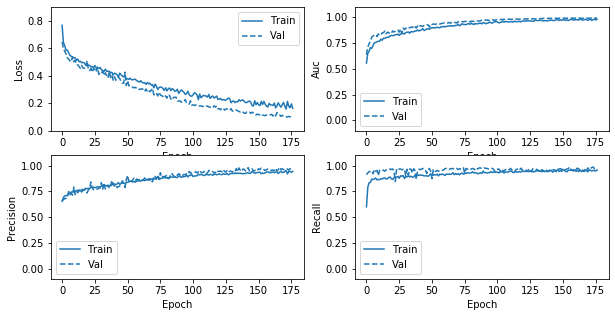

In [ ]:
plot_metrics(baseline_history6)

# Kinect with CNN

In [ ]:
file_dir = os.path.abspath('') # This returns the directory path that this script is in
# This will store arrays of data from files
features = []
# This will store 1 for good and 0 for wrong(bad)
labels = []
for csv_posix in Path(file_dir+'\distrib_kinect').iterdir():
    if csv_posix.suffix != ".csv":
        continue
    # Get the values in a form of an array
    d = pd.read_csv(str(csv_posix)).values
    # Append label to the label array based on file name
    if 'G' in csv_posix.stem or 'A' in csv_posix.stem:
        labels.append(1)
    else:
        labels.append(0)
    features.append(d)

# Convert them to numpy arrays, cause easier
features = np.array(features)
labels = np.array(labels)

# Scale the data
scalers = {}
for i in range(features.shape[1]):
    scalers[i] = StandardScaler()
    features[:, i, :] = scalers[i].fit_transform(features[:, i, :]) 

for i in range(features.shape[1]):
    features[:, i, :] = scalers[i].transform(features[:, i, :]) 

# Reshape
features=features.reshape(features.shape[0],features.shape[1],features.shape[2],1)

In [ ]:
# split data into train, test, val
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model4():
    model = Sequential()
    model.add(Conv2D(8, (1, 1), activation='tanh', input_shape=x_test[0].shape))
    model.add(MaxPool2D((1, 1), padding='same'))
    model.add(Conv2D(8, (2, 2), activation='tanh'))
    model.add(MaxPool2D((2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='tanh'))
    model.add(MaxPool2D((3, 3), padding='same'))
    model.add(Flatten())
    #model.add(Dense(16, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model4 = make_model4()
# check if model params do not exceed 2000
model4.summary()
model4.compile(optimizer=Adam(learning_rate = 3e-4), loss='binary_crossentropy', metrics=METRICS)
es = EarlyStopping(monitor='val_auc', verbose=0, patience=10, mode='max', restore_best_weights=True)
history4 = model4.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), verbose=0, batch_size=16, callbacks=[es])
baseline_results4 = model4.evaluate(x_test, y_test, batch_size=16, verbose=0)
                                
for name, value in zip(model4.metrics_names, baseline_results4):
    print(name, ': ', value)
print()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 39, 8)         16        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 39, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 38, 8)          264       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 19, 8)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 17, 16)         1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 6, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)               

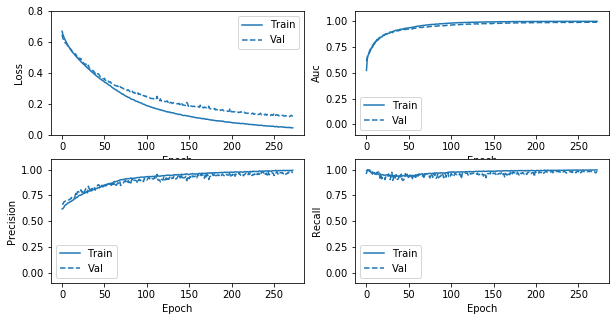

In [ ]:
plot_metrics(history4)